In [1]:
# Prepare imports and setup

In [2]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
# Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir='data', transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {'real': 0, 'fake': 1}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0] + '.jpg'
        label_str = self.data.iloc[idx, 1].strip().lower()
        label = self.label_map[label_str]

        # Folder path (inside 'data/')
        folder = 'real' if label == 0 else 'fake'
        img_path = os.path.join(self.root_dir, folder, img_name)

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Data preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset and DataLoader
dataset = ImageDataset(
    csv_file='drive/MyDrive/data/data.csv',
    root_dir='drive/MyDrive/data',
    transform=transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Device setup
device = torch.device("cpu")

# Try loading the model and weights
try:
    # Model Setup with Pretrained Weights
    model = models.resnet18(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier
    model.fc = nn.Linear(model.fc.in_features, 2)

    # Only final layer will be updated
    for param in model.fc.parameters():
        param.requires_grad = True

    model.to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]


Model loaded successfully!


In [ ]:
# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Acc: {val_accuracy:.2f}%")

Epoch 1, Train Loss: 0.3493, Val Loss: 0.1496, Val Acc: 95.35%
Epoch 2, Train Loss: 0.1897, Val Loss: 0.1032, Val Acc: 97.29%
Epoch 3, Train Loss: 0.1534, Val Loss: 0.0902, Val Acc: 96.90%
Epoch 4, Train Loss: 0.1593, Val Loss: 0.0849, Val Acc: 97.29%
Epoch 5, Train Loss: 0.1428, Val Loss: 0.0545, Val Acc: 98.06%


Epoch 1/50, Train Loss: 0.1017, Train Acc: 96.61%, Val Loss: 0.0429, Val Acc: 99.61%
Epoch 2/50, Train Loss: 0.1304, Train Acc: 94.76%, Val Loss: 0.1349, Val Acc: 94.57%
Epoch 3/50, Train Loss: 0.1125, Train Acc: 95.34%, Val Loss: 0.0384, Val Acc: 99.22%
Epoch 4/50, Train Loss: 0.0904, Train Acc: 96.70%, Val Loss: 0.0479, Val Acc: 98.06%
Epoch 5/50, Train Loss: 0.0825, Train Acc: 96.70%, Val Loss: 0.0399, Val Acc: 99.22%
Epoch 6/50, Train Loss: 0.0843, Train Acc: 97.48%, Val Loss: 0.0408, Val Acc: 98.45%
Epoch 7/50, Train Loss: 0.1277, Train Acc: 94.47%, Val Loss: 0.0376, Val Acc: 98.84%
Epoch 8/50, Train Loss: 0.0941, Train Acc: 96.41%, Val Loss: 0.0337, Val Acc: 99.61%
Epoch 9/50, Train Loss: 0.1052, Train Acc: 95.64%, Val Loss: 0.0396, Val Acc: 98.84%
Epoch 10/50, Train Loss: 0.0728, Train Acc: 97.09%, Val Loss: 0.0389, Val Acc: 98.45%
Epoch 11/50, Train Loss: 0.1528, Train Acc: 93.60%, Val Loss: 0.0548, Val Acc: 97.67%
Epoch 12/50, Train Loss: 0.1267, Train Acc: 95.05%, Val Loss: 0

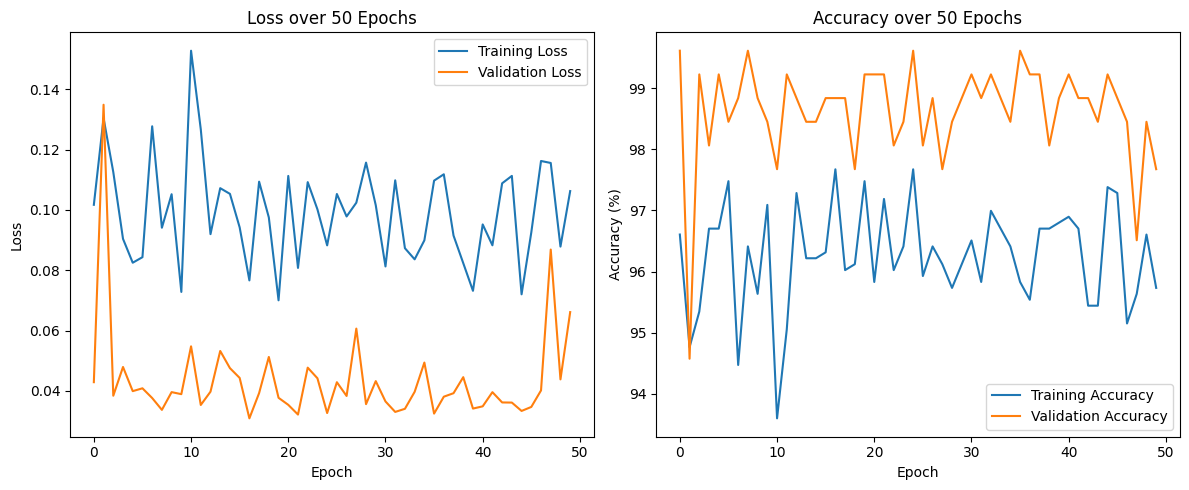

In [10]:
num_epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    scheduler.step()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_accuracy:.2f}%")

# Plotting the results
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over 50 Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over 50 Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
val_accuracies = [
    99.61, 94.57, 99.22, 98.06, 99.22, 98.45, 98.84, 99.61, 98.84, 98.45,
    97.67, 99.22, 98.84, 98.45, 98.45, 98.84, 98.84, 98.84, 97.67, 99.22,
    99.22, 99.22, 98.06, 98.45, 99.61, 98.06, 98.84, 97.67, 98.45, 98.84,
    99.22, 98.84, 99.22, 98.84, 98.45, 99.61, 99.22, 99.22, 98.06, 98.84,
    99.22, 98.84, 98.84, 98.45, 99.22, 98.84, 98.45, 96.51, 98.45, 97.67
]

avg_val_acc = sum(val_accuracies) / len(val_accuracies)
print(f"📊 Average Validation Accuracy: {avg_val_acc:.2f}%")

📊 Average Validation Accuracy: 98.63%


In [11]:
# Save model
torch.save(model.state_dict(), "ai_vs_human_ads_classifier_finetuned.pth")

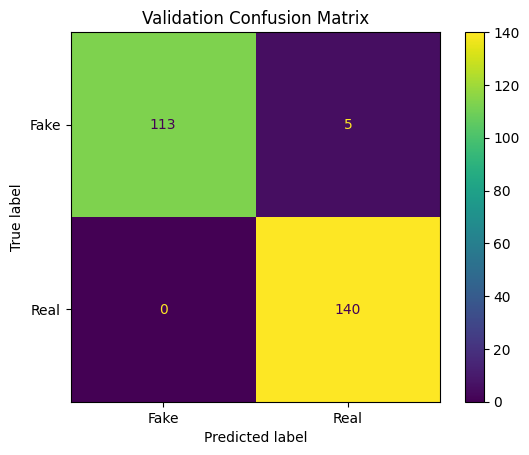

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot()
plt.title("Validation Confusion Matrix")
plt.show()